# Denoising DIC data using ResNet50

## **INDEX**

1. DIC Image DATA generator
2. Data Visualization
3. Resnet50 Architecture
4. U-net Architecture
5. Prediction 
6. Result plots

# Import libraries

In [1]:
import tensorflow.keras as keras
import os
import copy
import json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.interpolate import interp2d
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

2021-09-29 08:19:50.251538: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Data Generator

In [2]:

def dispgen(batch_size=32):
  SubsetSize = 256
  count = 1
  total=1000
  batch = np.zeros((n_batch,SubsetSize,SubsetSize))
  while True:
    for i in range(total):
      for l in range(batch_size):
            if (l <6):
                s = 128
            elif  (l<11):
                s = 64
            elif  (l<16):
                s = 32
            elif  (l<21):
                s = 16
            elif  (l<26):
                s = 8
            else:
                s = 4
            xp0=np.arange(1,SubsetSize/s+1,1/s)+2
            yp0=np.arange(1,SubsetSize/s+1,1/s)+2
            xxp0=np.arange(1,(SubsetSize/s)+4,1)
            yyp0=np.arange(1,(SubsetSize/s)+4,1)        
            u=random.randint(-100, 100, [int(SubsetSize/s+3),int(SubsetSize/s+3)])/115
            disp_u = interp2d(xxp0,yyp0,u,kind='cubic')
            disp_u_=disp_u(xp0,yp0)
            batch[count-1] = disp_u_
            count += 1
            if count == batch_size:
              retX = tf.convert_to_tensor(batch)
              batch = np.zeros((n_batch,SubsetSize,SubsetSize))
              count = 1
              Noise= retX+np.random.normal(0,0.2,batch.shape)
              yield Noise,retX
n_batch = 32
# call funtion to return generator object for displacement matrix
#def getImage(gen):
#  j = random.randint(0,n_batch-1)
#  batch = next(gen)
#  batch=tf.convert_to_tensor(batch)
#  return batch[0],batch[0]+np.random.normal(0,0.2,batch[0].shape)
Ugen = dispgen(n_batch)

# Data Visualization
Data Visualization is very important. When you know how your data looks then and then only you can process it in the way you want.

2021-09-29 08:20:04.533819: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-29 08:20:04.537617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-29 08:20:04.581911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-29 08:20:04.582545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-29 08:20:04.582606: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-29 08:20:04.627798: I tensorflow/stream_executor/platform/def

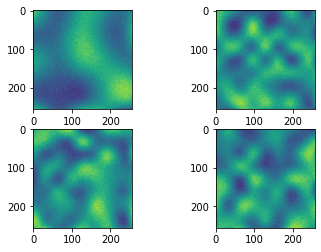

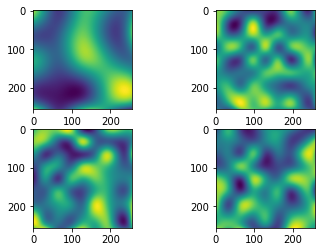

In [3]:
x,y=next(Ugen)                    #X are the noisy images wit Mean 0 and SD 0.2 and Y are the original images.
for index in range(0,4):          #ploting Noising Data 
  plt.subplot(220 + 1 + index)
  plt.imshow(x[index+10])
plt.show()

for index in range(0,4):        # ploting Orignal Images
  plt.subplot(220 + 1 + index)
  plt.imshow(y[index+10])

plt.show()

# Building A Resnet50 Architecture

In [ ]:
def resBlock(input_tensor, num_channels=1):
  conv1 = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
  relu  = Activation('relu')(conv1)
  conv2 = Conv2D(num_channels,(3,3),padding='same')(relu)
  add   = Add()([input_tensor, conv2])

  output_tensor = Activation('relu')(add)
  return output_tensor

def build_resnet_model(height,width,num_channels,num_res_blocks):
    inp       = Input(shape=(height,width,1))
    conv      = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)

    for i in np.arange(0,num_res_blocks):
        block_out = resBlock(block_out, num_channels)

    conv_m2   = Conv2D (1,(3,3),padding='same')(block_out)
    add_m2    = Add()([inp, conv_m2])
    model     = Model(inputs =inp,outputs = add_m2)

    return model

model = build_resnet_model(256,256,32,5)
model.summary()

# U-net Architecture


In [4]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [5]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    return conv

In [6]:
def unet_model(input_size=(256,256,1), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs,n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0],2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, 0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0],16*n_filters, 0.3, max_pooling=False) 
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8*n_filters)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Training


In [7]:
model=unet_model((256,256,1))
model.compile(optimizer= Adam(beta_2 = 0.9),loss='mean_squared_error',metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Creating a checkpoint for every epoch

In [8]:
checkpoint_path = "./"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
with tf.device('/device:GPU:0'):
  history=model.fit(Ugen,steps_per_epoch=1250,epochs=10)

2021-09-29 08:20:56.126087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-29 08:20:56.129162: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/10


2021-09-29 08:20:57.413135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-29 08:21:02.597795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-29 08:21:03.292717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


1250/1250 [==============================] - 423s 329ms/step - loss: 0.0065 - mse: 0.0065
Epoch 2/10
1250/1250 [==============================] - 411s 329ms/step - loss: 7.2500e-04 - mse: 7.2500e-04
Epoch 3/10
1250/1250 [==============================] - 411s 329ms/step - loss: 6.7389e-04 - mse: 6.7389e-04
Epoch 4/10
1250/1250 [==============================] - 410s 328ms/step - loss: 6.5265e-04 - mse: 6.5265e-04
Epoch 5/10
1250/1250 [==============================] - 410s 328ms/step - loss: 6.4295e-04 - mse: 6.4295e-04
Epoch 6/10
1250/1250 [==============================] - 410s 328ms/step - loss: 6.3630e-04 - mse: 6.3630e-04
Epoch 7/10
1250/1250 [==============================] - 411s 329ms/step - loss: 6.3163e-04 - mse: 6.3163e-04
Epoch 8/10
1250/1250 [==============================] - 411s 329ms/step - loss: 6.2839e-04 - mse: 6.2839e-04
Epoch 9/10
1250/1250 [==============================] - 410s 328ms/step - loss: 6.2556e-04 - mse: 6.2556e-04
Epoch 10/10
1250/1250 [===============

In [11]:
filepath='./Pbmodel1'
model.save(
    filepath, overwrite=True, include_optimizer=True,
    signatures=None, options=None, save_traces=True
)

# Prediction

In [12]:
x_test_noisy,x=next(Ugen)
response = model.predict(x_test_noisy)
response=np.squeeze(response,axis=-1)

Show some of the denoised examples.
Images from left to right are - Noisy image, original image, denoised image

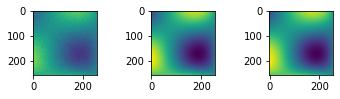

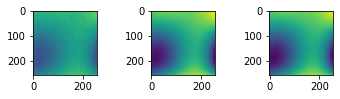

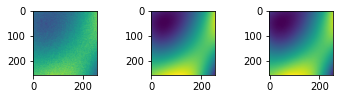

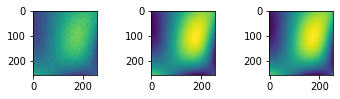

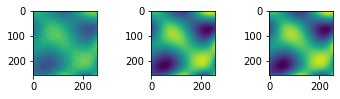

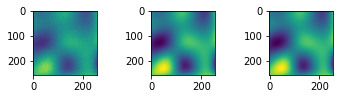

In [13]:
for index in range(24,30):
  plt.subplot(330 + 1)
  plt.imshow(x_test_noisy[index])
  plt.subplot(330 + 2)
  plt.imshow(x[index])
  plt.subplot(330 + 3)
  plt.imshow(response[index])
  plt.show()

# Result plots

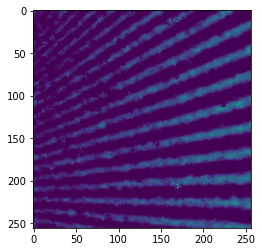

Noisy Image Data


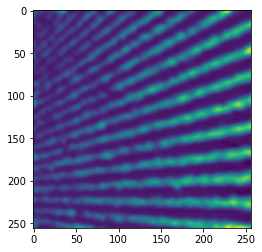

Denosed Image Data


In [28]:
from tensorflow.keras.preprocessing import image
img_path ='../input/dic-measurements/img2.jpg'
img = image.load_img(img_path, target_size=(256,256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x=tf.image.rgb_to_grayscale(x)
x1=model.predict(x)
plt.imshow(x[0])
plt.show()
print("Noisy Image Data")
plt.imshow(x1[0])
plt.show()
print("Denosed Image Data")

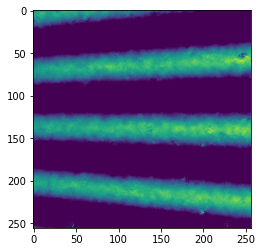

Noisy Image Data


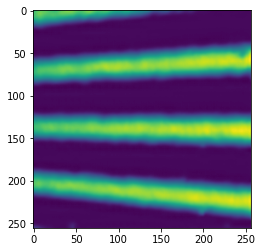

Denosed Image Data


In [29]:
from tensorflow.keras.preprocessing import image
img_path ='../input/dic-measurements/img1.jpg'
img = image.load_img(img_path, target_size=(256,256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x=tf.image.rgb_to_grayscale(x)
x1=model.predict(x)
plt.imshow(x[0])
plt.show()
print("Noisy Image Data")
plt.imshow(x1[0])
plt.show()
print("Denosed Image Data")

In [ ]:
avg_mse   = []
avg_mean  = []
avg_sd    = []

for index in range(0,3):
  avg_mean.append(np.mean(x[index] - response[index]))
  avg_mse.append(np.mean((x[index] - response[index])**2))
  avg_sd.append(np.std(x[index] - response[index]))

print("Mean:", np.sum(avg_mean)/11)
print("MSE:", np.sum(avg_mse)/11)
print("SD:", np.sum(avg_sd)/11)

In [15]:
model.save("model.h5")